## Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

To do: Take necessary actions to read the data
Importing all the important libraries

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

### Importing all the important libraries

In [35]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN.zip" > /dev/null

Data has been downloaded and stored in a folder 'images' divided into 'train' and 'test' folder.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset
Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

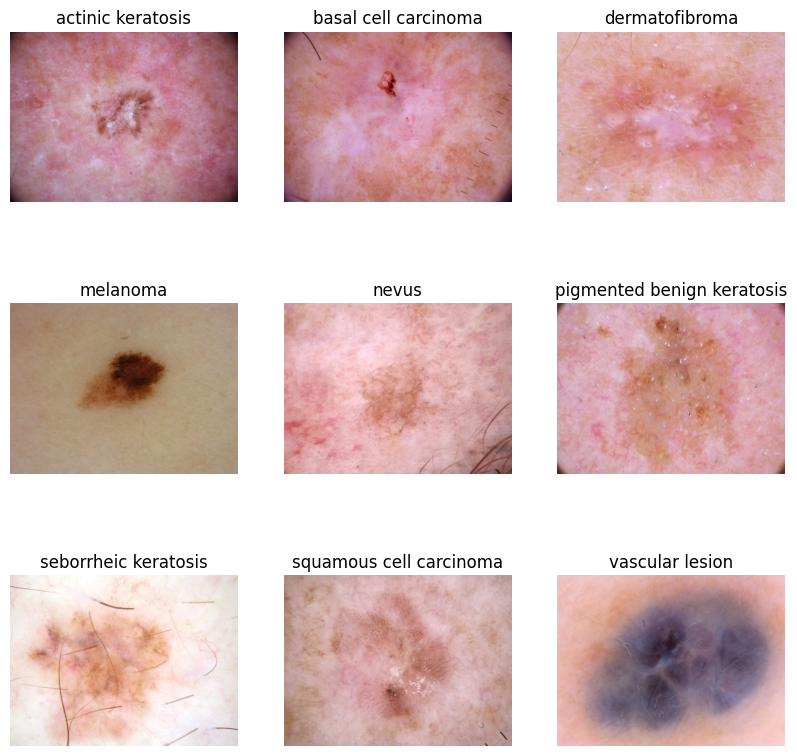

In [10]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. 
Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
The RGB channel values are in the [0, 255] range. 

This is not ideal for a neural network. 

Here, it is good to standardize values to be in the [0, 1]

In [12]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 27s 132ms/step - loss: 2.0589 - accuracy: 0.1842 - val_loss: 2.0475 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0128 - accuracy: 0.2048 - val_loss: 2.0403 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9539 - accuracy: 0.2500 - val_loss: 1.9333 - val_accuracy: 0.2438 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.8488 - accuracy: 0.2734 - val_loss: 1.7782 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7872 - accuracy: 0.3270 - val_loss: 1.7242 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7194 - accuracy: 0.3616 - val_loss: 1.6545 - val_accuracy: 0.4004 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 58ms/step - loss: 1

### Visualizing training results

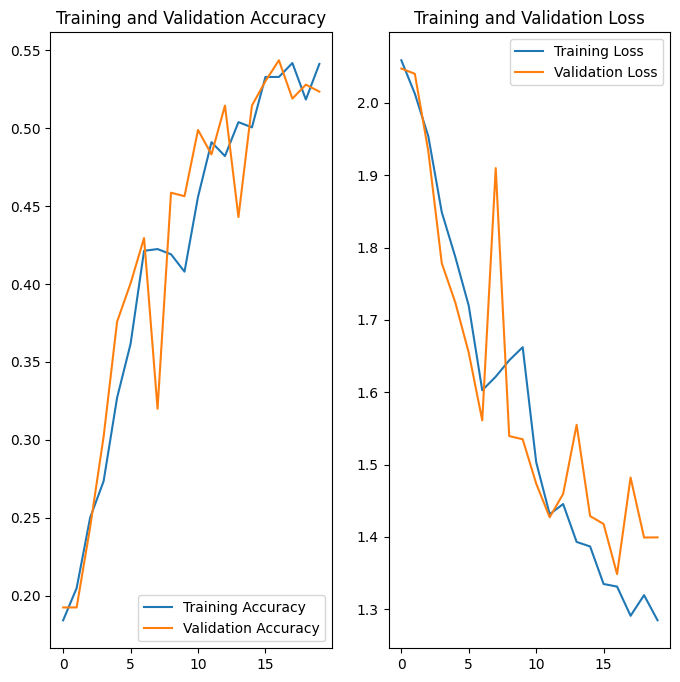

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Findings

The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting
Training loss is very low, but validation loss is fluctuating.
Thus we can collect that the model is not good.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

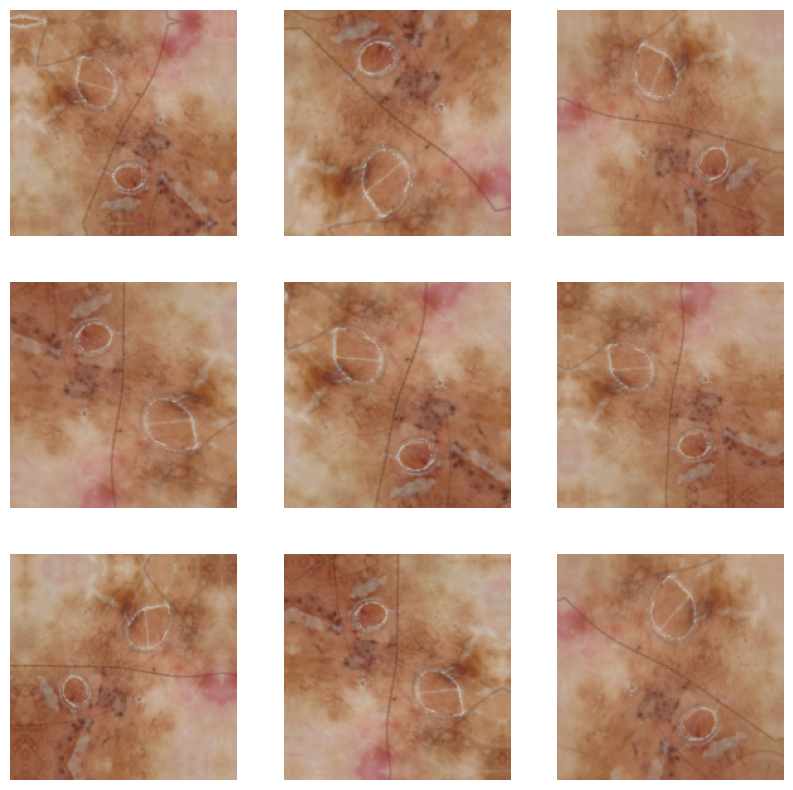

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Todo:
Create the model, compile and train the model

In [19]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

#### Compiling the model

In [20]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 7s 65ms/step - loss: 2.0777 - accuracy: 0.1931 - val_loss: 2.0691 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0204 - accuracy: 0.1948 - val_loss: 2.0073 - val_accuracy: 0.2908 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 1.9642 - accuracy: 0.2522 - val_loss: 2.0395 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 2.0229 - accuracy: 0.1886 - val_loss: 2.0232 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0177 - accuracy: 0.2042 - val_loss: 2.0281 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 2.0203 - accuracy: 0.1987 - val_loss: 2.0243 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 2.0186 -

### Visualizing the results

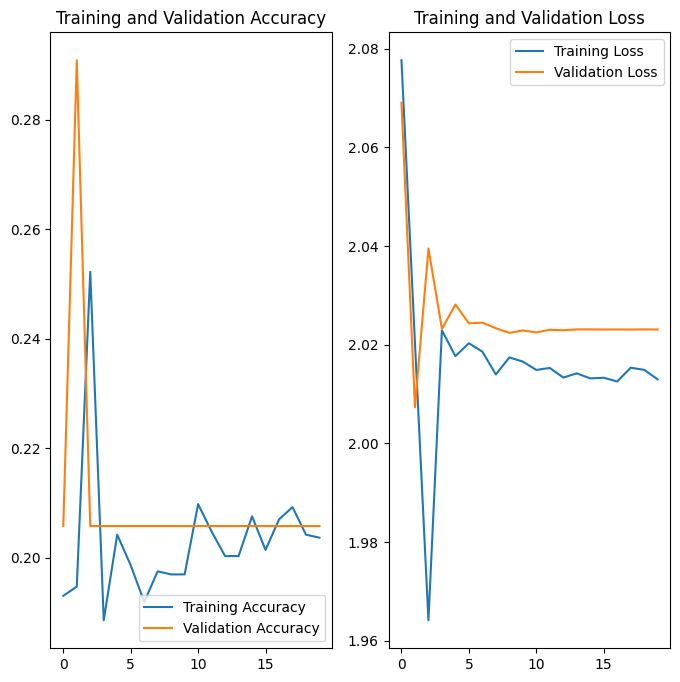

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Findings

1. The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.

#### Todo: Find the distribution of classes in the training dataset.

#### Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-24-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-24-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-24-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-24-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipy

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

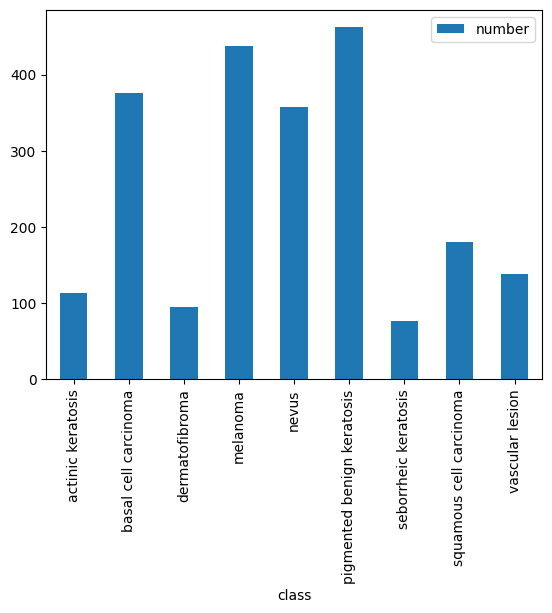

In [25]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

### Todo: Write your findings here:

### - Which class has the least number of samples?
#### seborrheic keratosis (77)

### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis (462)

### Todo: Rectify the class imbalance

### Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:

!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [27]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [29]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABF202C8580>: 100%|██████████| 500/500 [00:16<00:00, 30.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABF2010D450>: 100%|██████████| 500/500 [00:17<00:00, 28.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABEDB9D7FD0>: 100%|██████████| 500/500 [00:16<00:00, 29.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7ABEC41DB4C0>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7ABF3A7C6620>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABEDB9D6B30>: 100%|██████████| 500/500 [00:17<00:00, 28.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7ABF3A33D9C0>: 100%|██████████| 500/500 [00:40<00:00, 12.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABF204EEE60>: 100%|██████████| 500/500 [00:17<00:00, 28.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ABF3BC13220>: 100%|██████████| 500/500 [00:17<00:00, 28.61 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028200.jpg_609768ff-8d8c-4c53-a42d-6adb566b573a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026955.jpg_a73261fa-1359-47a7-9a2c-d14a161717ca.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024612.jpg_98a0c4a9-0833-4b8b-81ff-b473debb7e09.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026631.jpg_6b6b8335-dc22-471b-b0e8-711385f60689.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028646.jp

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    500
basal cell carcinoma          500
seborrheic keratosis          500
nevus                         500
melanoma                      500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
dermatofibroma                500
Name: Label, dtype: int64

#### Todo: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### Todo: Create a training dataset

In [42]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Todo: Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Todo: Create your model (make sure to include normalization)

In [45]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Todo: Compile your model (Choose optimizer and loss function appropriately)

In [46]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [47]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

#### Todo: Train your model

In [48]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/50
169/169 [==============================] - 40s 197ms/step - loss: 2.1550 - accuracy: 0.1563 - val_loss: 2.0841 - val_accuracy: 0.1589 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 30s 175ms/step - loss: 1.8663 - accuracy: 0.2693 - val_loss: 1.6079 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 30s 175ms/step - loss: 1.6714 - accuracy: 0.3531 - val_loss: 1.4797 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 34s 195ms/step - loss: 1.6050 - accuracy: 0.3802 - val_loss: 1.4225 - val_accuracy: 0.4573 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 30s 173ms/step - loss: 1.5143 - accuracy: 0.4071 - val_loss: 1.3647 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 30s 175ms/step - loss: 1.4437 - accuracy: 0.4314 - val_loss: 1.2788 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### Todo: Visualize the model results

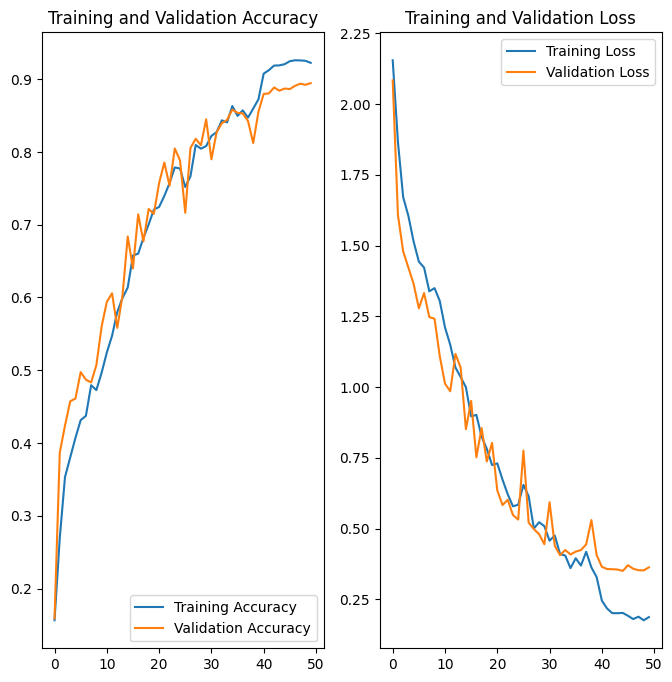

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Findings

The training accuracy and validation accuracy are almost same. This is a sign of good fit.
The training loss and validation loss are almost same. This is a sign of good fit.
The Validation accuracy is 0.87 which is good. The model is able to classify the images with 87% accuracy.

### Test the model

1/1 [==============================] - 0s 472ms/step
Actual Class: basal cell carcinoma
Predictive Class: squamous cell carcinoma


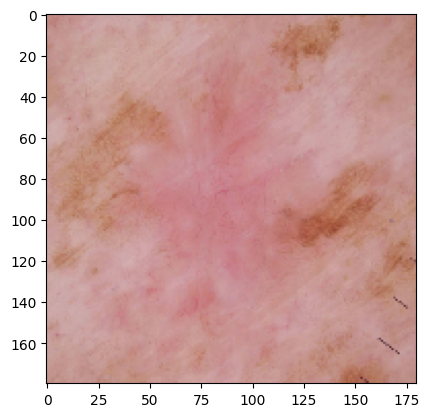

In [50]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)